## Попробуем Random Forest

## Нюанс тот же ...
Данные имеют временные метки. 
Соответственно, split обязательно должен быть по времени.
- и при разделении на train - test
- и при кроссвалидации.
  
Так же и нормализовывать данные необходимо после разбиения.
- однако в этом случае качество моделей падает ниже плинтуса, то на эту утечку пока забью...)

## 1. Импорты

In [1]:
# Импорт библиотек
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, clone
from sklearn.model_selection import train_test_split, StratifiedKFold, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                            precision_recall_curve, auc, confusion_matrix)
import time
import warnings
warnings.filterwarnings('ignore')

# Конфигурация
RANDOM_STATE = 42
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (8, 4)

## 2. Загрузка данных

In [2]:
# поиск пути от текущего файла в папку 
# anomaly_detection_project\data\raw где лежит датасет
def find_path_within_project(project_name, path_to_data):
    current_path = os.getcwd()   # путь к текущему файлу
  
    while True:
        # Проверяем, находится ли проект в текущем каталоге
        # если найден лепим и возвращаем нужный путь к данным
        if project_name in os.listdir(current_path):
            # Строим путь до нужной папки внутри проекта
            return os.path.join(current_path, project_name, path_to_data)
        
        parent_path = os.path.dirname(current_path)
        
        if parent_path == current_path:
            raise FileNotFoundError(f"Проект '{project_name}' не найден в родительских каталогах.")
        # если проекта нет поднимаемся выше
        current_path = parent_path

# Получаем путь
full_path_to_cc_1_02_00 = find_path_within_project(
    "anomaly_detection_project", 
    os.path.join("data", "raw",'creditcard_1_02_00.csv' )
)

In [3]:
# файл creditcard_1_02_00.csv лежит в папке data/raw/
# там добавлены новые колонки времени и суммы 
# print(f"Загрузка данных из {full_path}")
df = pd.read_csv(full_path_to_cc_1_02_00)

# посмотрим ка
print("\n")
print(f"Размер данных: {df.shape[0]} строк, {df.shape[1]} столбцов")
print(f"Распределение классов:\n{df['Class'].value_counts(normalize=True)}")
print(f"\nДанные. Первые строки:")
display(df.head())
print("Список колонок без PCA: \n", *df.columns[~df.columns.str.startswith('V')])



Размер данных: 284807 строк, 35 столбцов
Распределение классов:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

Данные. Первые строки:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V25,V26,V27,V28,Amount,Class,Time_hour,Time_day,Time_abs_hour,Amount_log
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.0,0.0,0.0,5.014760
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.0,0.0,0.0,1.305626
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.0,0.0,0.0,5.939276
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.0,0.0,0.0,4.824306
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.0,0.0,0.0,4.262539


Список колонок без PCA: 
 Time Amount Class Time_hour Time_day Time_abs_hour Amount_log


## 3. Выделение test

In [4]:
# колонка для сплита
time_column = 'Time_abs_hour'
df[time_column].min(), df[time_column].max()

(0.0, 47.0)

In [5]:
# Выделим для теста последние 8 часов
def get_train_test(df, col, train_finish,
                   train_start = 0, test_finish = 0, gap = 0,
                   easy_check =True):
    '''делим df на train и test 
        - gap -зазор между train и test (возможно и не пригодиццо)
    '''
    # определяем test_start и test_finish
    if test_finish == 0:
        test_finish = df[col].max()
    test_start = train_finish + gap + 1
    df_train = df[(df[col] >= train_start) & (df[col] <= train_finish)]
    df_test =  df[(df[col] >= test_start) & (df[col] <= test_finish)]
    if  easy_check:
        print("easy checking: \n",
              f"train min {df_train[col].min()}, train max {df_train[col].max()}\n" , 
              f"test min {df_test[col].min()}, test max {df_test[col].max()}")
    return df_train, df_test
    
time_col = 'Time_abs_hour'
train_finish = df[time_col].max() - 8
df_train, df_test = get_train_test(df, time_col , train_finish)
print("Отрезали тестовую выборку.")
print(f"Размеры train:{df_train.shape} test: {df_test.shape} .")


easy checking: 
 train min 0.0, train max 39.0
 test min 40.0, test max 47.0
Отрезали тестовую выборку.
Размеры train:(224865, 35) test: (59942, 35) .


## 4. Кросс валидация + обучение

In [6]:
# домашняя кросс валидация с учётом временных меток
# возвращает позиционные индексы
class my_Time_Series_Fold_for_df:
    def __init__(self, talker = True):
        self.folds = []
        self.talker = talker

    def split(self, df, time_col, n_folds, rolling_window= True):
        '''rolling_window - тактика формирования train'''
        # Получаем временные метки
        time_values = df[time_col]
        min_time = time_values.min()
        max_time = time_values.max()
        ############
        print(min_time, max_time)

        # Общая продолжительность временного интервала
        total_time = max_time + 1 - min_time

        # Границы фолдов
        fold_time_limits = [total_time*i/(n_folds+1) + min_time for i in range(n_folds+2)]
        if self.talker:
            print("\n*** my_Time_Series_Fold_for_df ***\n")
            print(fold_time_limits)

        for i in range(n_folds):
            # Временные границы обучающей выборки
            # в зависимости от стратегии
            train_time_start = fold_time_limits[
                    i if rolling_window else 0
                ]
            train_time_end =  fold_time_limits[i+1]

            # Временные границы тестовой выборки
            # test_time_start = train_time_end
            test_time_end = fold_time_limits[i+2]

            # Формируем обучающую и тестовую выборки
            train_idx = df[(df[time_col] >= train_time_start) & 
                            (df[time_col] < train_time_end)].index

            test_idx = df[(df[time_col] >= train_time_end) & 
                            (df[time_col] < test_time_end)].index

            # Преобразуем метки в позиции
            train_pos = df.index.get_indexer(train_idx)
            test_pos = df.index.get_indexer(test_idx)
            if self.talker:
                print(f"Номер фолда {i+1}")
                print(f"Размер train: {len(train_pos)}, test: {len(test_pos)}")

            # Добавляем пары индексов в список фолдов
            self.folds.append((train_pos, test_pos))

        return self.folds

time_separator = my_Time_Series_Fold_for_df()

In [37]:
# домашний unsupervised GridSearch для ocsvm, Isolation Forest, LOF
class my_GridSearchCV_2:
    '''
        Подбор гиперпараметров модели
        для обычных моделей 
        обучение на всех объектах
        cv - стратегия кросс валидации класс который формирует позиции 
        X_train, y_train, X_test,  y_test по временной колонке
        
        drop_columns - колонки которые не учавствуют в обучении и предсказании
        
    '''
    def __init__(self, model, param_grid, cv = time_separator,  scoring = f1_score,
                 time_col = "Time_abs_hour", n_folds = 3, n_samples = None, drop_columns = list(),
                 talker = True,
                 random_state=None):

        self.estimator = model
        self.drop_columns = drop_columns
        self.param_grid = list(ParameterGrid(param_grid))   # dict словарь параметров
        self.cv = cv                                        # стратегия кроссвалидации
        self.scoring = scoring                              # ф-я оценки (y_true, y_pred) -> float, например f1_score
        self.time_col = time_col
        self.n_folds = n_folds
        self.n_samples = n_samples
        self.talker = talker
        self.random_state = random_state
                        # стратегия кросс валидации и обучения итоговой модели

    def fit(self, X, y, rolling_window = True):
        """ Перебирает все комбинации параметров и заполняет cv_results_.
            - X - df
            - y - Series
            - rolling_window - тактика формирования train и обучения
        """

        # структуры для хранения результатов
        all_params = []
        mean_test_scores = []
        std_test_scores = []

        # получаем разбиение по фолдам
        train_test_positions = self.cv.split(X, self.time_col,
                                             self.n_folds, rolling_window)
        
        # добавляем в удаляемые колонку по которой делили
        self.drop_columns.append(time_col)

        # полный перебор
        for params in self.param_grid:
            test_scores = []

            # переделано под пандас получаем позици строк , не индексы!!!
            for train_pos, test_pos in train_test_positions:
                X_train, y_train = X.drop(self.drop_columns, axis=1).iloc[train_pos] , y.iloc[train_pos]
                X_test,  y_test  = X.drop(self.drop_columns, axis=1).iloc[test_pos] ,  y.iloc[test_pos]

                # если нужно уменьшить выборку для обучения LOF, OCSVM
                if self.n_samples is not None and self.n_samples < len(X_train) :
                    # np.random.seed(self.random_state)  # фиксируем генератор
                    # indices = np.random.choice(len(X_train), size=self.n_samples, replace=False)
                    # X_train = X_train.iloc[indices]
                    # y_train = y_train.iloc[indices]
                    X_train, y_train = self.get_samples_(X_train, y_train, self.n_samples)

                # рожаем модель
                model = clone(self.estimator).set_params(**params)
                model.fit(X_train, y_train)

                # предсказания на test
                y_pred = model.predict(X_test)
                test_scores.append(self.scoring(y_test, y_pred))

            all_params.append(params)
            mean_test_scores.append(np.mean(test_scores))
            std_test_scores.append(np.std(test_scores))
            if self.talker:
                print(f"\nПараметры {params}")
                print(f"mean_scores {mean_test_scores[-1]}")
                print(f"std {std_test_scores[-1]}")

        # собираем cv_results_
        # можно докинуть потом 'rank_test_score', 
        #'split0_test_score', 'split1_test_score', ...: оценки на каждом фолде
        # 'mean_fit_time', 'mean_score_time': время обучения и оценки
        cv_results = {
            'params': all_params,
            'mean_test_score': np.array(mean_test_scores),
            'std_test_score':  np.array(std_test_scores),
        }

        # сохраняем результаты
        self.cv_results_  = cv_results

        # выбираем лучший индекс по mean_test_score
        best_idx = np.argmax(cv_results['mean_test_score'])
        self.best_params_  = all_params[best_idx]
        self.best_score_   = cv_results['mean_test_score'][best_idx]
        self.best_estimator_ = clone(self.estimator).set_params(**self.best_params_)

        # обучаем лучший на всей выборке кроме колонок которые нужно дропнуть
        X = X.drop(self.drop_columns, axis=1)
        # если тактика rolling_window обучаем только на данных последнего фолда
        if rolling_window:
            X, y  = X.iloc[test_pos] ,  y.iloc[test_pos]

        # если нужно уменьшить выборку для обучения 
        if self.n_samples is not None and self.n_samples *2 < len(X):
            X, y = self.get_samples_(X, y, self.n_samples *2 )

        self.best_estimator_.fit(X, y)
        return

    def get_samples_(self, X, y, n_samples):
        '''X - df , y - Series
           сохраняем все аномалии'''
        # Разделяем на положительный и отрицательный класс
        anom_idx = y[y == 1].index
        norm_idx = y[y == 0].index
    
        # Сколько брать нормы, чтобы вместе с аномалией получилось n_samples
        n_norm = n_samples - len(anom_idx)
    
        # Сэмплируем только из нулевого класса
        np.random.seed(self.random_state)  # фиксируем генератор
        norm_sampled = np.random.choice(norm_idx, size = n_norm, replace = False)
    
        # Объединяем индексы
        sampled_idx = np.concatenate([anom_idx, norm_sampled])

        return X.loc[sampled_idx],  y.loc[sampled_idx]
        

    def predict(self, X):
        """
        Предсказывает метки для X, используя best_estimator_.
        Возвращает 1 для мошенников и 0 для нормы
        """
        self.check_best_estimator()
        X = X.drop(self.drop_columns, axis=1)
        return self.best_estimator_.predict(X)

    def decision_function(self, X):
        """
        Возвращает значение типа decision_function от best_estimator_.
        или 
        """
        self.check_best_estimator()  
        X = X.drop(self.drop_columns, axis=1)
        # Используем вероятность  как "оценку"
        proba = self.best_estimator_.predict_proba(X)[:, 1]
        # чтобы граница была в 0 чем выше , тем выше вероятность аномалии
        return proba - 0.5

    def check_best_estimator(self):
        """
        проверка наличия обученого моделя
        """
        if not hasattr(self, 'best_estimator_'):
            raise AttributeError("Нужно сначала вызвать .fit()")

In [33]:
# для предсказания оставляем только колонки с PCA признаками и Amount_log ???
# Предобработка
drop_cols = ['Class']

X = df_train.drop(drop_cols, axis=1)
y = df_train['Class']

X_test = df_test.drop(drop_cols, axis=1)
y_test = df_test['Class']

In [34]:
print("Данные содержат колонки: ", X.columns)

Данные содержат колонки:  Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Time_hour', 'Time_day', 'Time_abs_hour', 'Amount_log'],
      dtype='object')


In [35]:
# для предсказания ни временные колонки ни величина транзакций нам не нужны
# кроме PCA колонок оставляем только  'Time_abs_hour' по ней будем бить на фолды
unnecessary_cols = ['Time', 'Amount', 'Time_hour', 'Time_day', 'Amount_log'] 

In [50]:
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

param_rf = {
    'n_estimators': [200, 100],
    'max_depth': [ None ]
}
grid_rf =  my_GridSearchCV_2(
    model=rf,
    param_grid=param_rf, 
    time_col = time_column,
    n_folds = 3,
    n_samples = 3000,
    drop_columns=unnecessary_cols,
    random_state = RANDOM_STATE
)
grid_rf.fit(X, y, rolling_window=False)

print( '\n Лучшие параметры модели: ', grid_rf.best_params_)

0.0 39.0

*** my_Time_Series_Fold_for_df ***

[0.0, 10.0, 20.0, 30.0, 40.0]
Номер фолда 1
Размер train: 30596, test: 80256
Номер фолда 2
Размер train: 110852, test: 45528
Номер фолда 3
Размер train: 156380, test: 68485

Параметры {'max_depth': None, 'n_estimators': 200}
mean_scores 0.6759177145142058
std 0.20765341611506496

Параметры {'max_depth': None, 'n_estimators': 100}
mean_scores 0.66675999115335
std 0.22404420786601653

 Лучшие параметры модели:  {'max_depth': None, 'n_estimators': 200}


## 5. Оценка

In [46]:
###############################################################
# precision-recall кривая и confusion_matrix и метрики

# метрики печать и возвращаем f1, pr_auc
def print_metrics(y_true, y_pred,  pr_auc):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print('\n'+'='*60)
    print(f"Precision={precision:.2f},   Recall={recall:.2f},   F1={f1:.2f},   PR_AUC={pr_auc:.2f}")
    print('\n'+'='*60)
    # return f1, pr_auc

# precision-recall кривая и confusion_matrix
def plot_pr_curve_and_conf_matrix(model, X, y_true, main_label = ''):
    # 0) получаем предсказания и сырые и не очень)
    # получаем сырые оценки 
    y_scores = model.decision_function(X)
    
    # и предсказания
    y_pred = model.predict(X)

    # 1) оценка pr_curve
    precisions, recalls, _ = precision_recall_curve(y_true, y_scores)
    # x  должен монотонно возрастать!!!!
    pr_auc = auc(x = recalls, y = precisions)

    # 2)отрисовка
    # # Создаём общую фигуру с 2 подграфиками (по горизонтали)
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    # pr curve
    fig.suptitle("Оценка модели " + main_label, fontsize=14, fontweight='bold')
    
    
    labels = ['Норм (0)', 'Аномалии (1)']
    
    axs[0].plot(recalls, precisions, marker='.', color='teal')
    axs[0].set_xlabel("Recall")
    axs[0].set_ylabel("Precision")
    axs[0].set_title(f"PR Curve (AUC={pr_auc:.2f})")
    
    # cm
    cm = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, ax=axs[1])
    axs[1].set_xlabel("Предсказаные метки")
    axs[1].set_ylabel("Истинные метки")
    axs[1].set_title("Confusion Matrix")
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3) # раздвигаем картинки
    plt.show()
    
    # 3) печать метрик
    print_metrics(y_true, y_pred,  pr_auc)
    
    pass


################################################################

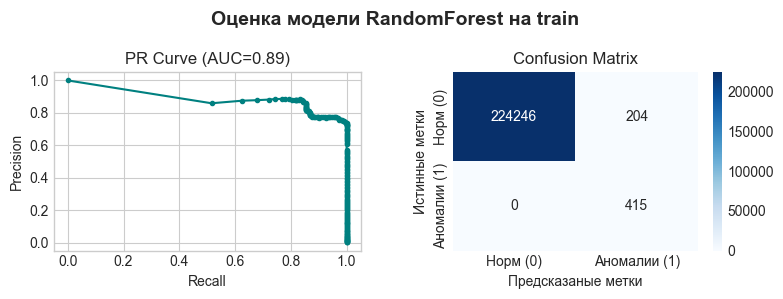


Precision=0.67,   Recall=1.00,   F1=0.80,   PR_AUC=0.89



In [47]:
# Оценка на train
plot_pr_curve_and_conf_matrix(
    grid_rf, 
    X,
    y,'RandomForest на train' 
)

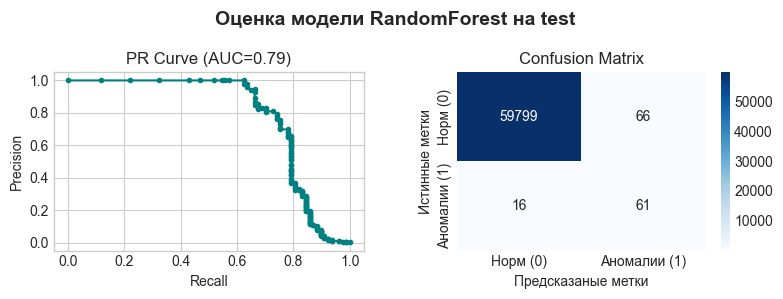


Precision=0.48,   Recall=0.79,   F1=0.60,   PR_AUC=0.79



In [48]:
# Оценка на test
plot_pr_curve_and_conf_matrix(
    grid_rf, X_test,
    y_test,'RandomForest на test' 
)

### Заметно значительное улучшение результатов.
**Добавим экземпляров выборки в обучение**


In [51]:
grid_rf =  my_GridSearchCV_2(
    model=rf,
    param_grid=param_rf, 
    time_col = time_column,
    n_folds = 3,
    n_samples = 15000,
    drop_columns=unnecessary_cols,
    random_state = RANDOM_STATE
)
grid_rf.fit(X, y, rolling_window=False)

print( '\n Лучшие параметры модели: ', grid_rf.best_params_)

0.0 39.0

*** my_Time_Series_Fold_for_df ***

[0.0, 10.0, 20.0, 30.0, 40.0]
Номер фолда 1
Размер train: 30596, test: 80256
Номер фолда 2
Размер train: 110852, test: 45528
Номер фолда 3
Размер train: 156380, test: 68485

Параметры {'max_depth': None, 'n_estimators': 200}
mean_scores 0.7811106104601853
std 0.08428049790146179

Параметры {'max_depth': None, 'n_estimators': 100}
mean_scores 0.774378419166195
std 0.1005923281905395

 Лучшие параметры модели:  {'max_depth': None, 'n_estimators': 200}


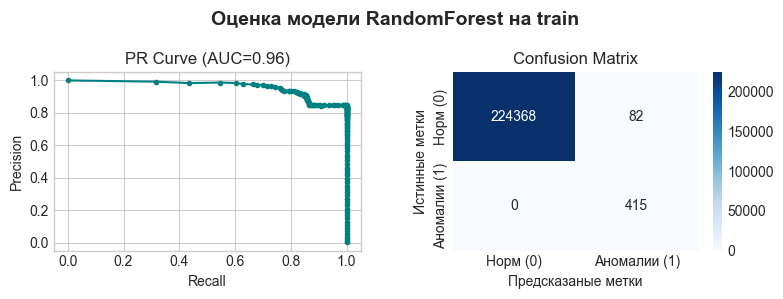


Precision=0.84,   Recall=1.00,   F1=0.91,   PR_AUC=0.96



In [52]:
# Оценка на train
plot_pr_curve_and_conf_matrix(
    grid_rf, 
    X,
    y,'RandomForest на train' 
)

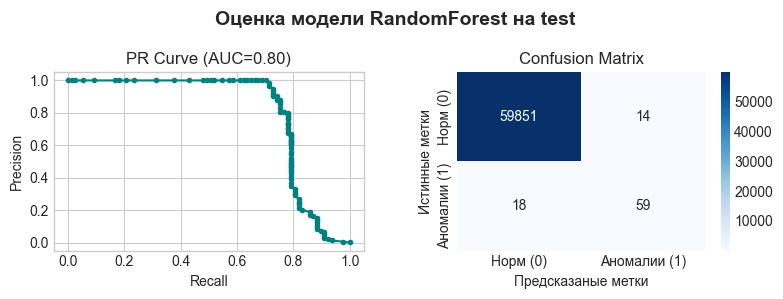


Precision=0.81,   Recall=0.77,   F1=0.79,   PR_AUC=0.80



In [53]:
# Оценка на test
plot_pr_curve_and_conf_matrix(
    grid_rf, X_test,
    y_test,'RandomForest на test' 
)

## 6. Выводы

**Датасет**
- **Объём**: 284 807 транзакций, 35 признаков.
- **Ну очень сильный дисбаланс**: 0,17% транзакций — мошеннические (Class == 1).

**Временное разбиение**: данные разделены по `Time_abs_hour`:
  - **Train**: 0–39 часов (224 865 строк).  
  - **Test**: 40–47 часов (59 942 строк).
  
**Модель**  
- **Random Forest**
  
**Метрики**  | F1   | PR AUC |
- **Train**   | 0.91 | 0.96   |
- **Test**     | 0.77 | 0.80   |
  
  
**Вывод**
- **Random Forest в текущем виде уже неплохо справляется с задачей** даже несмотря на очень сильный дисбаланс.
- **Supervised-подход (Random Forest) кардинально превосходит Unsupervised-подход (LOF)** на этой задаче.
- **Качество, при желании, можно улучшать:**
- - настройка гиперпараметров Random Forest/LightGBM/CatBoost.
  - Генерация новых признаков на основе анализа ошибок.
  - Ансамблировании лучших -моделей.

## Happy end.....